# Support Vector Machine (a.k.a. Large Margin Classification)

<img src="machine-learning-inside.gif" />

## Table Of Contents

1. Implemented SVM with Gaussian kernel
2. Reallife example
3. Error Analysis

# 1 SVM Implementation with Gaussian Kernel

## 1.1 Boring stuff ... installing packages, importing things, fixing the world

In [1]:
!pip install plotly

In [45]:
# importing required modules
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib.ticker as mticker
import scipy.optimize
import sklearn.svm
import sklearn.datasets
import sklearn.model_selection
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

# some high DPI settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1.2 Goal

1. Create training set generator
2. Define cost function
3. Minimize cost function
4. Profit.

## 1.3 Training set

Generating a training set from random values of a normal distribution. Let $m$ be the amount of training examples. We simply pick $\frac{m}{2}$ randomly distributed (normal distribution, in this example with $\sigma = 0.5$ and $\mu_x = 1, \mu_y = 0$). Each training example is a vector where its first item $x_0^{(i)} = 1$, $x_1^{(i)}$ is generated by $\mathcal{N}(\sigma, \mu_x)$ and $x_2^{(i)}$ is generated by $\mathcal{N}(\sigma, \mu_y)$. All corresponding training targets are set to $y = 0$. We end up with a matrix (data) and a vector (targets). We repeat this procedure with $\mu_x = -1$ and $y = 1$. Construct the training set:

$$X = \left( \begin{array}{ccc}
x_0^{(1)} & x_1^{(1)} & x_2^{(1)} \\
x_0^{(2)} & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
x_0^{(m/2)} & x_1^{(m/2)} & x_2^{(m/2)} \\
x_0^{(m/2+1)} & x_1^{(m/2+1)} & x_2^{(m/2+1)} \\
\vdots & \vdots & \vdots \\
x_0^{(m)} & x_1^{(m)} & x_2^{(m)} \\
\end{array} \right) = \left( \begin{array}{ccc}
1 & x_1^{(1)} & x_2^{(1)} \\
1 & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
1 & x_1^{(m/2)} & x_2^{(m/2)} \\
1 & x_1^{(m/2+1)} & x_2^{(m/2+1)} \\
\vdots & \vdots & \vdots \\
1 & x_1^{(m)} & x_2^{(m)} \\
\end{array} \right)\qquad y = \left( \begin{array}{c}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m/2)} \\
y^{(m/2+1)} \\
\vdots \\
y^{(m)} \\
\end{array} \right) = \left( \begin{array}{c}
0 \\
0 \\
\vdots \\
0 \\
1 \\
\vdots \\
1 \\
\end{array} \right)$$

### Shuffling

Because we generate first negative examples ($y = 0$) and then positive examples ($y = 1$) it is generally a good idea to shuffle the rows of the training set (the order of the examples). This is done by

1. Initialize $P = I$ (identity matrix)
2. Shuffle $P$
3. Apply permutation to training set: $X = PX$ and $y = Py$

Why not shuffle $X$ and $y$ directly? Because we must shuffle $X$ and $y$ with the same permutation. Furthermore `numpy` can shuffle a 1d-list but not a 2d-matrix. So we have to do that manually.

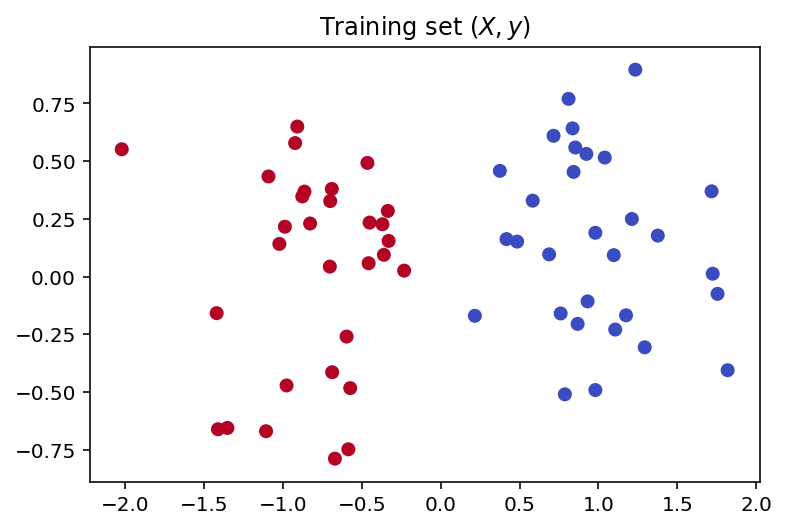

In [74]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 60
half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,   # first half of the training set
    np.array(gaussian2d(-1, 0, sigma, half_m)).T   # second half of the training set
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m), # setting results to 0
    np.repeat(1, half_m)  # setting results to 1
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

# permutate X and y with P
X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

# add ones for x_0
X = np.c_[ np.ones((m, 1)), X ]

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.title("Training set $(X, y)$")
plt.show()

In [75]:
print("   x0 |   x1 |   x2 |   y")
for v in np.c_[ X[:15], y[:15] ]:
    print(" {:>4.1f} | {:>4.1f} | {:>4.1f} | {:>4.1f} ".format(v[0], v[1], v[2], v[3]))
print("  ...    ...    ...    ...")

   x0 |   x1 |   x2 |   y
  1.0 |  0.9 |  0.5 |  0.0 
  1.0 |  0.7 |  0.1 |  0.0 
  1.0 | -1.1 |  0.4 |  1.0 
  1.0 |  0.8 |  0.6 |  0.0 
  1.0 | -0.9 |  0.6 |  1.0 
  1.0 |  1.8 | -0.1 |  0.0 
  1.0 | -0.7 |  0.4 |  1.0 
  1.0 |  0.8 | -0.5 |  0.0 
  1.0 |  0.2 | -0.2 |  0.0 
  1.0 |  1.2 |  0.9 |  0.0 
  1.0 | -0.7 | -0.8 |  1.0 
  1.0 |  1.0 | -0.5 |  0.0 
  1.0 |  1.2 | -0.2 |  0.0 
  1.0 |  1.4 |  0.2 |  0.0 
  1.0 | -1.0 |  0.1 |  1.0 
  ...    ...    ...    ...


## 1.4 Cost function *J*

### Linear kernel (no kernel)

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T x^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T x^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

### Gaussian kernel

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T f^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T f^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

$$J\big(\theta\big) = C \Big( c_1^T y + c_0^T (1 - y) \Big) + \frac{1}{2} \Vert\theta\Vert^2$$

$C$ is the regularization parameter, $c_1$ and $c_0$ are the vectors of all partial costs, $y$ is the training result vector. We obtain $c_1$ and $c_0$ by computing

In [76]:
def J(theta, F, y, C):
    z = np.dot(theta, F)
    c1 = cost1(z)
    c0 = cost0(z)
    sum1 = np.dot(c1, y)
    sum0 = np.dot(c0, (1 - y))
    return C * (sum1 + sum0) + 0.5 * LA.norm(theta[1:])**2

## 1.5 Gaussian Kernel (Radial Basis Function, a.k.a. RBF kernel)

... computes the similarity between two vectors $x$ and $l$ (given $\sigma$ or $\gamma = \frac{1}{2\sigma^2}$) $$k(x, l) = \exp\Bigg(- \frac{\big\Vert x - l \big\Vert^2}{2\sigma^2}\Bigg) = \exp\Big(- \gamma \Vert x - l \Vert^2\Big)$$

## 1.6 Feature Matrix

Given a training set $x^{(0)}, x^{(1)}, \dots, x^{(m)} \in \mathbb{R}^{m+1}$, define $l^{(0)} = x^{(0)}, l^{(1)} = x^{(1)}, \dots, l^{(m)} = x^{(m)} \in \mathbb{R}^{m+1}$.

Define the feature matrix $F$ so that $$f_{ij} = k(x^{(j)}, l^{(i)}) = \exp\Big(- \frac{\Vert x^{(j)} - l^{(i)} \Vert^2}{2\sigma^2}\Big)$$

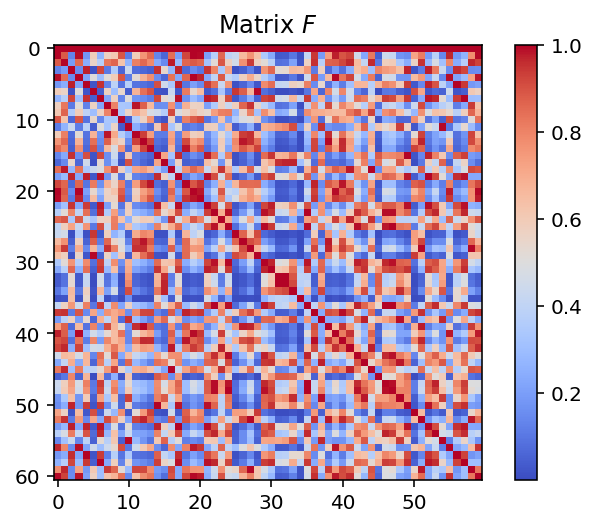

In [77]:
kernel = lambda x, l, sigma: np.exp(- (LA.norm(x - l, ord=2)**2) / (2 * sigma**2))

m = X.shape[0]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X[i], X[j - 1], 1))
F = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m), dtype=int)
F[0, :] = 1

plt.imshow(F, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $F$")
plt.show()

## 1.7 Helper functions (Sigmoid, Costs)

### Sigmoid

$$g(z) = \frac{1}{1 + e^{-z}}$$

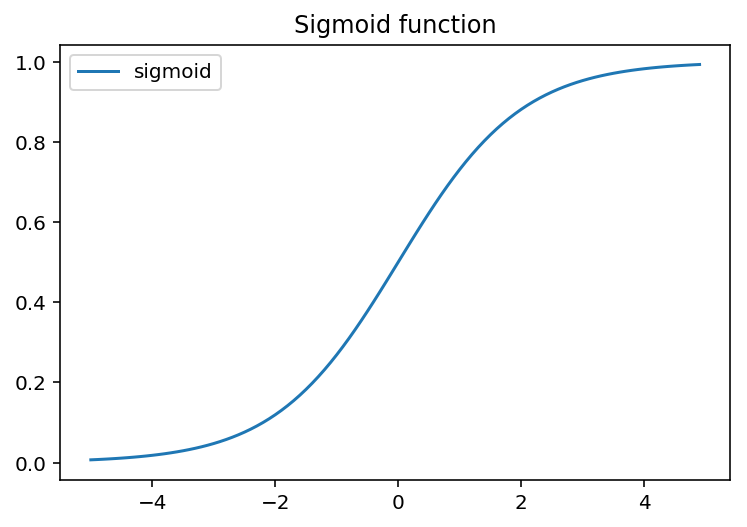

In [78]:
x = np.arange(-5, 5, 0.1)

g = lambda z: 1 / (1 + np.exp(-z)) # sigmoid function g

plt.plot(x, g(x), label="sigmoid")
plt.legend()
plt.title("Sigmoid function")
plt.grid()
plt.show()

### Cost function

... that $y = 1$: $\quad\text{cost}_1(z) = -\log\big(g(z)\big)$

and that $y = 0$: $\quad\text{cost}_0(z) = -\log\big(1 - g(z)\big)$

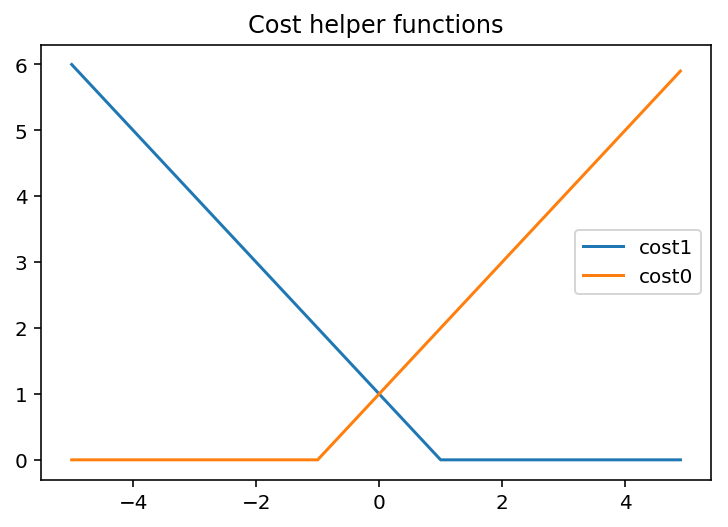

In [79]:
#cost1 = lambda z: -np.log(g(z))     # cost function for y = 1
#cost0 = lambda z: -np.log(1 - g(z)) # cost function for y = 0

cost1 = lambda z: np.where(z < 1, -z + 1, 0)
cost0 = lambda z: np.where(z > -1, z + 1, 0)

plt.plot(x, cost1(x), label="cost1")
plt.plot(x, cost0(x), label="cost0")
#plt.plot(x, cost1_(x), label="cost1 new")
#plt.plot(x, cost0_(x), label="cost0 new")
plt.legend()
plt.title("Cost helper functions")
plt.grid()
plt.show()

## 1.8 Finding a minimum

We will get a minimum $\theta$ by minimizing the cost function. This $\theta$ is the normal vector of the decision boundary.

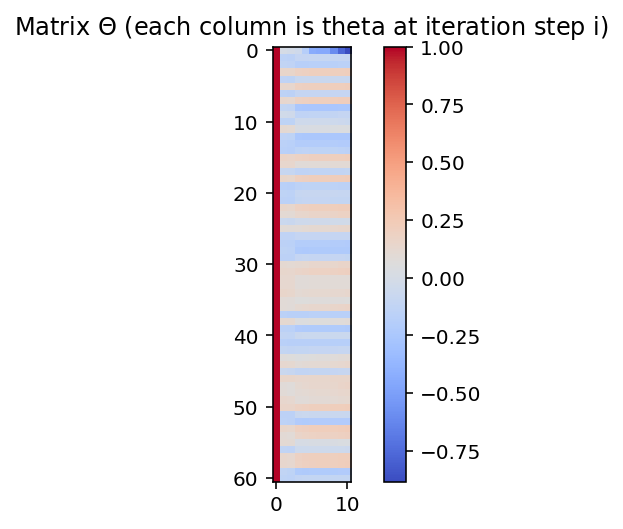

In [80]:
m = X.shape[0]
theta_matrix = np.ones(shape=(m + 1, 1))

def callback(theta):
    global theta_matrix
    theta_matrix = np.c_[ theta_matrix, theta ]

minimum = scipy.optimize.minimize(
    lambda theta: J(np.array(theta), F, y, C=1), x0=(0,)*(m + 1),
    callback=callback
)

theta = minimum.x

plt.imshow(theta_matrix, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.title("Matrix $\Theta$ (each column is theta at iteration step i)")
plt.show()

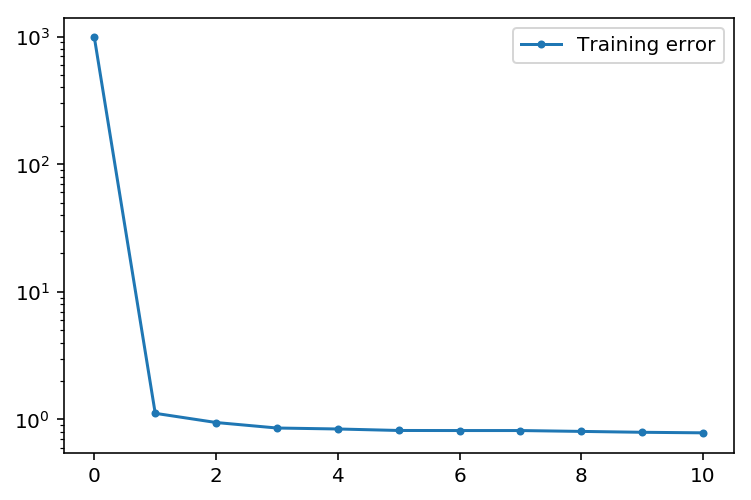

In [81]:
training_error = np.apply_along_axis(lambda theta: J(np.array(theta), F, y, C=1), axis=0, arr=theta_matrix)

plt.semilogy(training_error, label="Training error", marker=".")
plt.legend()
plt.grid()
plt.show()

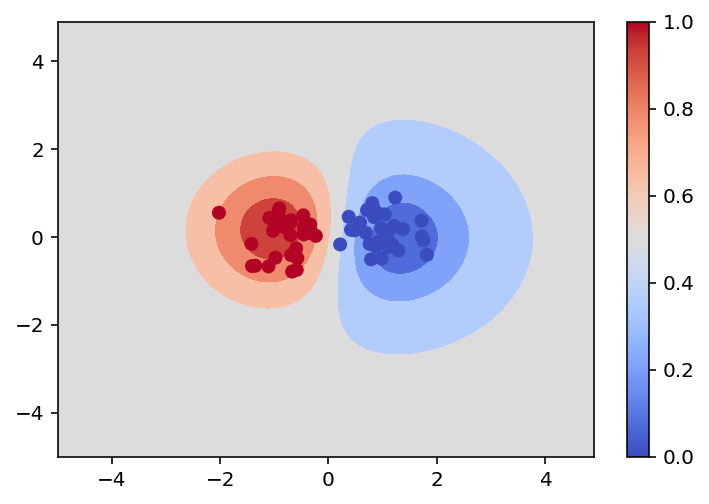

In [82]:
xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))

m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ]

vectorized_kernel = np.vectorize(lambda i, j: kernel(X_mesh[i], X[j - 1], 1))
F_ = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m_mesh), dtype=int)
F_[0, :] = 1

Z = np.dot(theta, F_)

plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

In [83]:
py.iplot([ go.Surface(x=xx, y=yy, z=Z.reshape(xx.shape))])

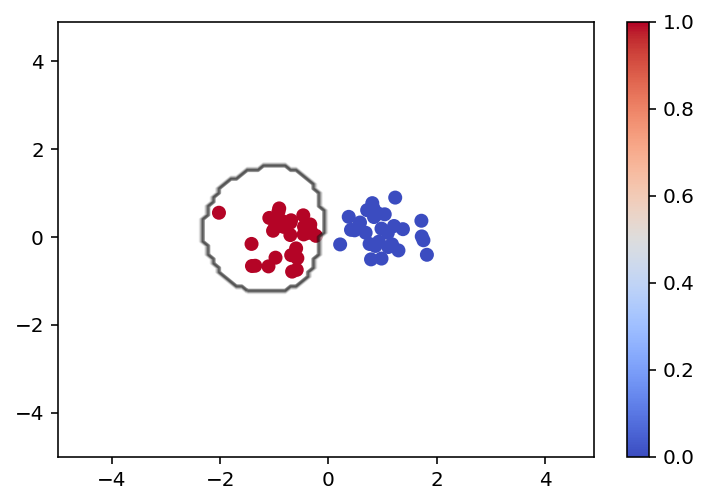

In [84]:
Z_classes = np.vectorize(lambda z: 1 if z > 0.5 else 0)(Z.reshape(xx.shape))

plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.35)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.show()

## 1.9 Using a library

Why use a library? Performance-tuned implementation of several solving algorithms. Up to 100x faster than the manual implementation above.

### Gaussian kernel

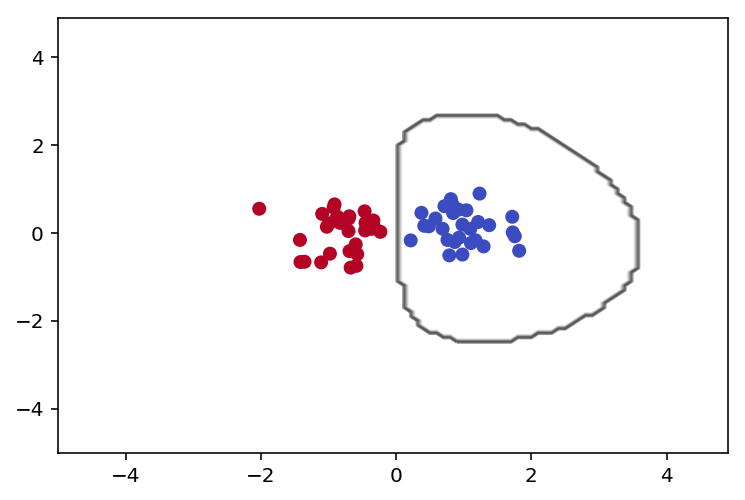

In [95]:
classifier = sklearn.svm.SVC(kernel="rbf", gamma=0.5)
classifier.fit(X, y)

Z_classes = classifier.predict(np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ])
Z_classes = Z_classes.reshape(xx.shape)

plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.35)
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.show()

### Linear kernel

$$J\big(\theta\big) = C \Big( c_1^T y + c_0^T (1 - y) \Big) + \frac{1}{2} \Vert\theta\Vert^2$$

When choosing a high $C$ the optimization algorithm tries to find a small solution $\theta$ to minimize the cost function. A high $C$ makes the solution prone to underfitting (biased solution), whereas a low $C$ allows a larger $\theta$ which means that the solution is more prone to overfitting.

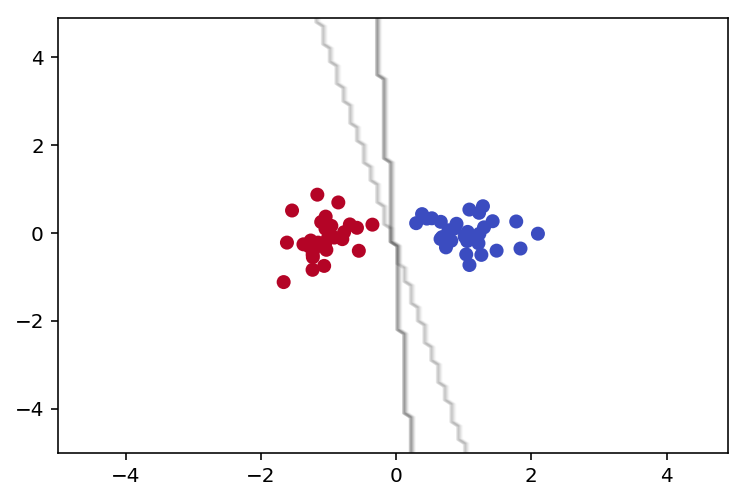

In [30]:
for c in [ 1, 10, 10000 ]:
    classifier = sklearn.svm.SVC(kernel="linear", C=c)
    classifier.fit(X, y)
    
    Z_classes = classifier.predict(np.c_[ np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()])
    Z_classes = Z_classes.reshape(xx.shape)
    plt.contour(xx, yy, Z_classes, cmap=plt.cm.binary, alpha=0.1)

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
plt.show()

# 2 MNIST digit recognition with SVM

## 2.1 Downloading dataset & feature scaling

In [125]:
mnist = sklearn.datasets.fetch_mldata('MNIST original', data_home='./')
X = mnist.data / 255.0
y = mnist.target
X.shape, y.shape

((70000, 784), (70000,))

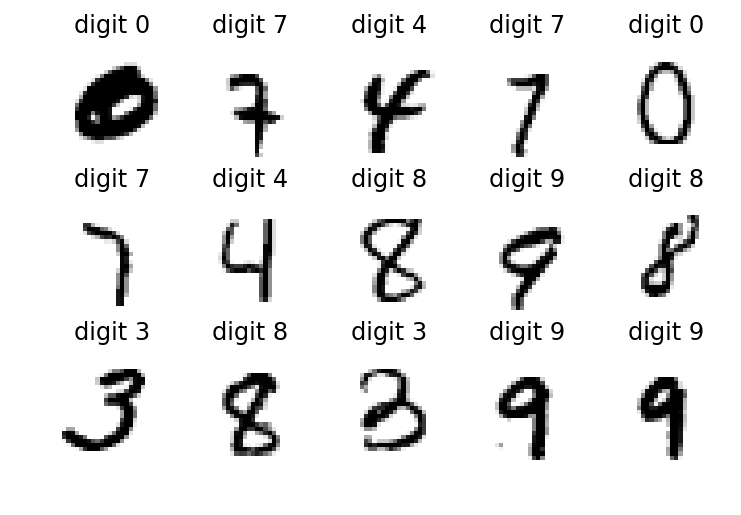

In [126]:
for i in range(15):
    example_index = int(np.random.rand(1)[0] * mnist.data.shape[0])
    plt.subplot(3, 5, i + 1)
    plt.imshow(mnist.data[example_index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title("digit {}".format(int(mnist.target[example_index])))
    plt.axis("off")
plt.show()

## 2.2 Training set, test set

We will use 30% of the training data as test set.

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

## 2.3 Train SVM with linear kernel (no kernel)

In [ ]:
# ETA 3 min
linear_classifier = sklearn.svm.SVC(kernel="linear", verbose=True)
linear_classifier.fit(X_train, y_train)

In [ ]:
# ETA 3 min
linear_classifier.score(X_test, y_test)

### Some predictions from the test set

In [ ]:
for i in range(15):
    test_index = int(np.random.rand(1)[0] * X_test.shape[0])
    predicted = linear_classifier.predict(X_test[test_index].reshape(1, -1))[0]
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[test_index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title("p={}, t={}".format(int(predicted), int(y_test[test_index])))
    plt.axis("off")
plt.show()

## 2.4 Train SVM with RBF kernel (Radial Basis Function Kernel)

In [ ]:
# ETA 9 min
rbf_classifier = sklearn.svm.SVC(kernel="rbf", verbose=True)
rbf_classifier.fit(X_train, y_train)

In [ ]:
# ETA 6 min
rbf_classifier.score(X_test, y_test)

### Some predictions from the test set

In [ ]:
for i in range(15):
    test_index = int(np.random.rand(1)[0] * X_test.shape[0])
    predicted = rbf_classifier.predict(X_test[test_index].reshape(1, -1))[0]
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[test_index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title("p={}, t={}".format(int(predicted), int(y_test[test_index])))
    plt.axis("off")
plt.show()

### Handwritten prediction

In [ ]:
data = np.array([255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,249,219,243,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,253,187,95,92,216,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,235,118,70,168,240,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,220,81,97,226,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,203,64,123,244,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,212,57,138,252,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,244,82,105,251,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,161,49,223,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,249,75,122,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,200,39,201,255,251,225,211,222,245,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,139,64,249,212,104,88,105,96,94,139,192,246,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,103,95,176,60,137,234,251,242,204,152,89,92,215,255,255,255,255,255,255,255,255,255,255,255,255,255,255,250,77,47,50,177,255,255,255,255,255,255,244,94,91,252,255,255,255,255,255,255,255,255,255,255,255,255,255,247,67,13,128,255,255,255,255,255,255,255,255,134,67,248,255,255,255,255,255,255,255,255,255,255,255,255,255,249,71,111,248,255,255,255,255,255,255,255,231,61,136,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,142,57,211,248,255,255,255,252,229,169,82,101,238,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,242,134,86,100,120,128,124,107,88,110,184,247,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,239,211,188,182,184,202,231,254,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,])

data = 1.0 - (data / 255.0)

plt.imshow(data.reshape((28, 28)), cmap=plt.cm.binary)
plt.title("Handwritten example")
plt.axis("off")
plt.show()

print("Prediction:", rbf_classifier.predict(data.reshape(1, -1))[0])

## 2.5 Problem with MNIST data set

In [ ]:
# ones start at training example #5923 in the MNIST data set
# twos start at training example #12665 in the MNIST data set

for count, index in enumerate(np.random.randint(low=5923, high=12664, size=130)):
    plt.subplot(10, 13, count + 1)
    plt.imshow(mnist.data[index].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
plt.show()

# 3 Error Analysis

* Compute errors
    * `classifier.score()`
    * Precision, Recall, F-score
    * Cross-Validation error, Training error (with `.score()`)
* DONE: Training set generator v2
* Regularization: fix over-/underfitting by choosing $C$ or $\lambda$
    * Cost function: explain what different values of $C$ achieve
    * overfitting: too many features, fails to generalize
* Learning curves
    * decide if more training data makes predictions better
    * plots for high bias/high variance (see Xournal)
    * extrapolation
* Parameters of other kernels (RBF: gamma?)
* Correlation

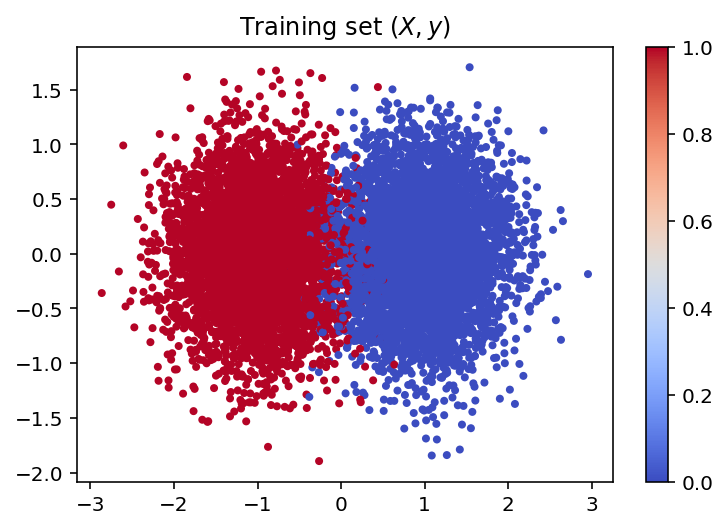

In [2]:
gaussian2d = lambda x, y, sigma, n: (np.random.normal(x, sigma, n), np.random.normal(y, sigma, n))

m = 10000
half_m = int(m / 2)
sigma = 0.5

X = np.concatenate((
    np.array(gaussian2d(1, 0, sigma, half_m)).T,   # first half of the training set
    np.array(gaussian2d(-1, 0, sigma, half_m)).T   # second half of the training set
), axis=0)

y = np.concatenate((
    np.repeat(0, half_m), # setting results to 0
    np.repeat(1, half_m)  # setting results to 1
), axis=0)

permutation = np.eye(m)
np.random.shuffle(permutation)

# permutate X and y with P
X = np.matmul(permutation, X)
y = np.matmul(permutation, y)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker=".")
plt.colorbar()
plt.title("Training set $(X, y)$")
plt.show()

In [3]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 2), (3000, 2), (7000,), (3000,))

## 3.2 Regularization

$$J\big(\theta\big) = C \sum_{i = 1}^{m} \Big[ y^{(i)} \text{cost}_1\big(\theta^T f^{(i)}\big) + \big(1 - y^{(i)}\big) \text{cost}_0\big(\theta^T f^{(i)}\big) \Big] + \frac{1}{2} \sum_{j = 1}^{n}\theta^2_j$$

Simplified:

$$ \min_{\theta} J\big(\theta\big) = \min_{\theta} C \cdot \theta \cdot x + \Vert\theta\Vert^2$$

* high $C$ $\rightarrow$ low $\theta$ (prone to underfitting)
* low $C$ $\rightarrow$ high $\theta$ (prone to overfitting)

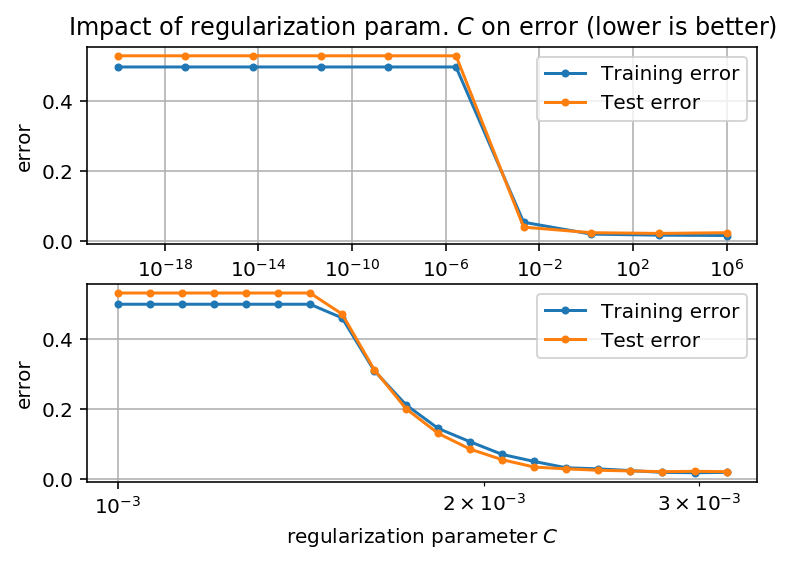

In [6]:
cc = np.logspace(start=-20, stop=6, num=10, base=10)
training_error = []
test_error = []
regularization_classifier = sklearn.svm.SVC(kernel="rbf")
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 1)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.title("Impact of regularization param. $C$ on error (lower is better)")
plt.ylabel("error")
plt.grid()

cc = np.logspace(start=-3, stop=-2.5, num=20, base=10)
training_error = []
test_error = []
for C in cc:
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:1000], y_train[:1000])
    training_error.append(1 - regularization_classifier.score(X_train[:1000], y_train[:1000]))
    test_error.append(1 - regularization_classifier.score(X_test[:1000], y_test[:1000]))

plt.subplot(2, 1, 2)
plt.semilogx(cc, training_error, label="Training error", marker=".")
plt.semilogx(cc, test_error, label="Test error", marker=".")
plt.legend()
plt.xlabel("regularization parameter $C$")
plt.ylabel("error")
plt.grid()

plt.show()

1e-20 10.0
2.3357214690901214e-19 10.0
5.455594781168514e-18 10.0
1.274274985703132e-16 10.0
2.976351441631313e-15 10.0
6.951927961775592e-14 10.0
1.6237767391887243e-12 10.0
3.7926901907322536e-11 10.0
8.858667904100832e-10 10.0
2.0691380811147902e-08 10.0
4.832930238571752e-07 10.0
1.1288378916846883e-05 10.0
0.00026366508987303664 10.0
0.006158482110660279 10.0
0.1438449888287666 10.0
3.359818286283788 10.0
78.47599703514622 10.0
1832.9807108324376 10.0
42813.32398719396 10.0
1000000.0 10.0
1e-20 14.116818860225736
2.3357214690901214e-19 14.116818860225736
5.455594781168514e-18 14.116818860225736
1.274274985703132e-16 14.116818860225736
2.976351441631313e-15 14.116818860225736
6.951927961775592e-14 14.116818860225736
1.6237767391887243e-12 14.116818860225736
3.7926901907322536e-11 14.116818860225736
8.858667904100832e-10 14.116818860225736
2.0691380811147902e-08 14.116818860225736
4.832930238571752e-07 14.116818860225736
1.1288378916846883e-05 14.116818860225736
0.000263665089873036

5.455594781168514e-18 443.7161776628455
1.274274985703132e-16 443.7161776628455
2.976351441631313e-15 443.7161776628455
6.951927961775592e-14 443.7161776628455
1.6237767391887243e-12 443.7161776628455
3.7926901907322536e-11 443.7161776628455
8.858667904100832e-10 443.7161776628455
2.0691380811147902e-08 443.7161776628455
4.832930238571752e-07 443.7161776628455
1.1288378916846883e-05 443.7161776628455
0.00026366508987303664 443.7161776628455
0.006158482110660279 443.7161776628455
0.1438449888287666 443.7161776628455
3.359818286283788 443.7161776628455
78.47599703514622 443.7161776628455
1832.9807108324376 443.7161776628455
42813.32398719396 443.7161776628455
1000000.0 443.7161776628455
1e-20 626.386090541813
2.3357214690901214e-19 626.386090541813
5.455594781168514e-18 626.386090541813
1.274274985703132e-16 626.386090541813
2.976351441631313e-15 626.386090541813
6.951927961775592e-14 626.386090541813
1.6237767391887243e-12 626.386090541813
3.7926901907322536e-11 626.386090541813
8.85866

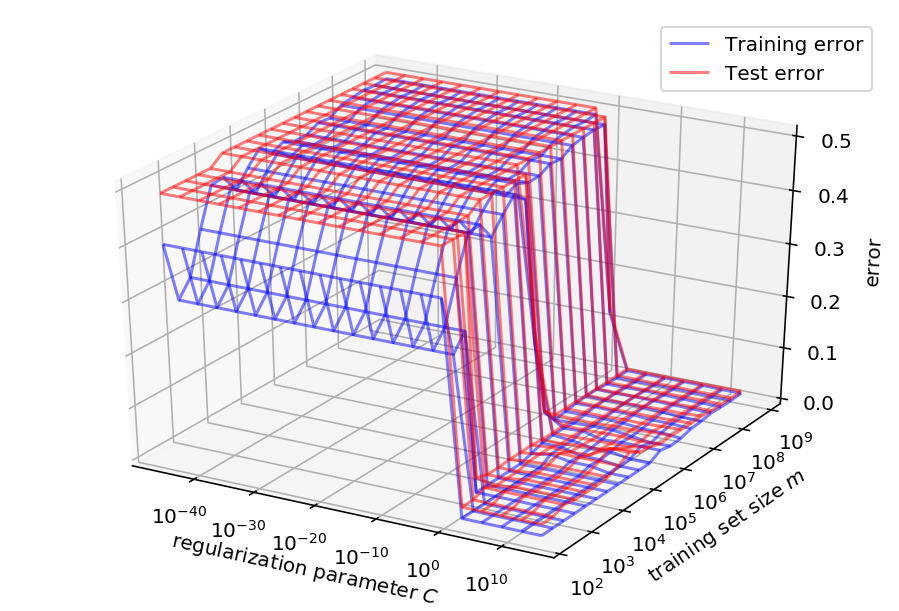

In [69]:
cc = np.logspace(start=-20, stop=6, num=20, base=10) # TODO: stop=6
sizes = np.logspace(start=1, stop=3.845, num=20, base=10)
xx, yy = np.meshgrid(cc, sizes)
m_mesh = xx.ravel().shape[0]
X_mesh = np.c_[ xx.ravel(), yy.ravel() ]

#training_error = []
#test_error = []
regularization_classifier = sklearn.svm.SVC(kernel="rbf")

def error(C, size):
    print(C, size)
    size = int(size)
    regularization_classifier.set_params(C=C)
    regularization_classifier.fit(X_train[:size], y_train[:size])
    training_error = 1 - regularization_classifier.score(X_train[:size], y_train[:size])
    test_error = 1 - regularization_classifier.score(X_test, y_test)
    return (training_error, test_error)

#Z = np.fromfunction(np.vectorize(lambda j, i: error(X_mesh[i, 0], X_mesh[i, 1])), shape=(m_mesh, m_mesh), dtype=int)

Z = np.apply_along_axis(lambda x: error(x[0], x[1]), axis=1, arr=X_mesh)

#vectorized_error = np.vectorize(lambda i, j: kernel(X_mesh[i], X[j - 1], 1))
#F_ = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m_mesh), dtype=int)
#F_[0, :] = 1

#for C in cc:
#    for size in sizes:
#        size = int(size)
#        regularization_classifier.set_params(C=C)
#        regularization_classifier.fit(X_train[:size], y_train[:size])
#        training_error.append(1 - regularization_classifier.score(X_train[:size], y_train[:size]))
#        test_error.append(1 - regularization_classifier.score(X_test, y_test))

#py.iplot([ go.Surface(x=xx, y=yy, z=Z[:, 0].reshape(xx.shape))])

#plt.semilogx(sizes, training_error, label="Training error", marker=".")
#plt.semilogx(sizes, test_error, label="Test error", marker=".")
#plt.legend()
#plt.title("Impact of training set size $m$ on error (lower is better)")
#plt.xlabel("training set size $m$")
#plt.ylabel("error")
#plt.grid()
#plt.show()



#xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
#
#m_mesh = xx.ravel().shape[0]
#X_mesh = np.c_[ np.ones((m_mesh, 1)), xx.ravel(), yy.ravel() ]
#
#vectorized_kernel = np.vectorize(lambda i, j: kernel(X_mesh[i], X[j - 1], 1))
#F_ = np.fromfunction(lambda j, i: vectorized_kernel(i, j), shape=(m + 1, m_mesh), dtype=int)
#F_[0, :] = 1
#
#Z = np.dot(theta, F_)
#
#plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.coolwarm)
#plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.coolwarm)
#plt.colorbar()
#plt.show()

fig = plt.figure()
ax = Axes3D(fig)

ax.plot_wireframe(np.log(xx), np.log(yy), Z[:, 0].reshape(xx.shape), label="Training error", color="blue", alpha=0.5)
ax.plot_wireframe(np.log(xx), np.log(yy), Z[:, 1].reshape(xx.shape), label="Test error", color="red", alpha=0.5)

def log_tick_formatter(val, pos=None):
    return "$10^{%i}$" % int(val)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("regularization parameter $C$")
ax.set_ylabel("training set size $m$")
ax.set_zlabel("error")
ax.legend()

plt.show()

In [27]:
py.iplot([
    go.Scatter3d(x=xx, y=yy, z=Z[:, 0].reshape(xx.shape)),
    go.Scatter3d(x=xx, y=yy, z=Z[:, 1].reshape(xx.shape))
], layout=go.Layout(
    xaxis = { "type": "log", "autorange": True },
    yaxis = { "type": "log", "autorange": True }
))

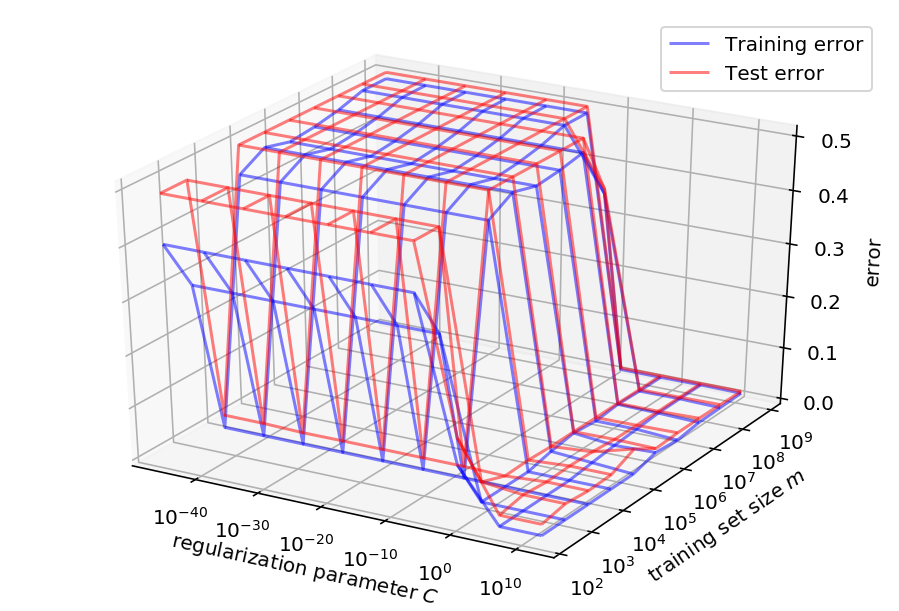

In [68]:
fig = plt.figure()
ax = Axes3D(fig)

ax.plot_wireframe(np.log(xx), np.log(yy), Z[:, 0].reshape(xx.shape), label="Training error", color="blue", alpha=0.5)
ax.plot_wireframe(np.log(xx), np.log(yy), Z[:, 1].reshape(xx.shape), label="Test error", color="red", alpha=0.5)

def log_tick_formatter(val, pos=None):
    return "$10^{%i}$" % int(val)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.set_xlabel("regularization parameter $C$")
ax.set_ylabel("training set size $m$")
ax.set_zlabel("error")
ax.legend()

plt.show()

# Fork on GitHub!

<img src="qr-code-to-github-repo.svg" />

<center>https://github.com/NIPE-SYSTEMS/support-vector-machine</center>